# Assignment Instructions
## Completing the Assignment  
1. Fill in your STUDENTID (abc123) in the code block below.
2. Fill in any place that says `#YOUR CODE HERE` with python code that implements the indicated function.
3. When filling in `#YOUR CODE HERE` sections, remove or comment out the line  `raise NotImplementedError()`, or else you will lose all credit for that function.
4. Fill in any place that says `YOUR ANSWER HERE` with appropriate markdown text. This usually indicates a manually graded cell.

## Assignment Submission Checklist  
Before you submit this assignment for grading, you must do the following or you risk losing points. 
1. **Remove extraneous prints** Long prints _might_ confuse the grader. If they do, you lose points.
2. **Restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart)
3. **Run all cells** (in the menubar, select Cell$\rightarrow$Run All).  
  - If any cell that contains code throws an exception or does not compile, fix it and restart this checklist 
  - If a grading cell throws an exception, you will not recieve any credit for that cell
4. **Save the notebook** This ensures that any graphs or plots are in the submission   
  - Do NOT rename your notebook. It must have the same name that was downloaded, or the grading will fail.  
5. **Zip up the assignment notebook(s) and any files required to run the notebook**
  - You must put your files into a `.zip` file with the same name that was used to download the assignment. For example `ASnn.zip` or `PRnn.zip` where nn is a two digit, zero padded number.
  - All files must be in the root of the zip file, NOT in a subdirectory

By submitting this notebook for grading, you affirm that all work was produced by the author identified below, and that references are included for all use of public source material (to include code, data, diagrams, pictures, and verbatim text).

In [1]:
STUDENTID = "tfs436"

---

# AS11: Exploring Networks
**Version:**  1.2  
**Total Points:** 5

## Objective
The objective of this assignment is to become familiar with creating and working with networks (graphs) using NetworkX.

## Instructions

**Word Graphs**  

[Build a Graph from Text](#Build-a-Graph-from-Text) (1.0)  
[Compare Graph Information](#Compare-Graph-Information) (0.5)  
[Compare Centrality Measures](#Compare-Centrality-Measures) (0.5)  
[Normalize Edges](#Normalize-Edges) (0.5)  
[Generate Sentences](#Generate-Sentences) (1.0)  
[Visualize a Word Graph](#Visualize-a-Word-Graph) (reference only)  

**Graph Structures**  
[Scale-free Networks](#Scale-free-Networks)  
[Small-world Networks](#Small-world-Networks)  
[Compare Network Structures](#Compare-Network-Structures) (0.5)  
[Plot Network Degree Distribution](#Plot-Network-Degree-Distribution) (0.5)  
[Structure for Word Networks](#Structure-for-Word-Networks) (0.5)  

**Geographic Networks**  
[The osmnx Library](#The-osmnx-Library) (reference only)  




## Setup

In [2]:
%matplotlib inline
# Imports and globals for this exercise
# mainline tools
import os
import re
import string
import math
import itertools
# data tools
import pandas as pd
import numpy as np

# visualization tools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import mplleaflet
# text tools
import nltk
# Network tools
import networkx as nx
import graphviz as pgv
import pydot
import osmnx as ox

# Use seaborn theme, scaling, and color palette.
import seaborn as sns
sns.set()
# Styling seems more consistent if set using MPL instead of sns
plt.style.use('seaborn-whitegrid')

# Set paths to directories for the data
dataroot = os.environ['DATASETS_ROOT']


## Utilities

In [3]:
def read_text(sPath):
    with open(sPath, 'r', encoding='utf8') as f:
        sText = f.read()        
    return( sText )    

## Word Graphs

### Utility functions for the word networks

In [4]:
# Check whether two graphs are equal. For this exercise, 
# just need to check that the probability for each edge is the same.
# Depending on the method used to construct the graph, the specific order
# the edges may not be the same, so we can't check the cumulative probability.
def word_graph_is_isomorphic(G1, G2):
    def node_comparison(N1, N2):
        return N1['count'] == N2['count']
    def edge_comparison(E1,E2):
        return E1['prob'] == E2['prob']
    return(nx.is_isomorphic(G1, G2, node_match=node_comparison, edge_match=edge_comparison))

def list_start_words(G):
    return sorted([t for t, data in G.nodes(data=True) if data['bStart'] ])

def list_end_tokens(G):
    return sorted([t for t, data in G.nodes(data=True) if data['bEnd'] ])

### Build a Graph from Text
**Points: 1.0**

If you consider that a sentence is a directed progression from one word to the next, then we can build a directed network from a text. This next function accepts text as an input. The text we will be using has been preprocessed to avoid some complications. All sentences end in either a period (.), question mark (?), or exclamation point (!). 

To create the graph:
- Use the standard NLTK sentence tokenizer to break the input text into sentences
- Use the standard NLTK word tokenizer to break each sentence into a sequence of tokens
- Create (or update) a node for each token to include the attributes listed below. Use the token as the node name.
- Create (or update) an edge to connect a token to the one that follows it to include the edge attributes listed below.
- **Do not** connect the last token in a sentence to the first token in the next sentence.

**Graph Attributes**

| Attribute | Data Type | Description |
| :--- | :--- | :--- |
| name | String | Name associated with the graph |

**Node Attributes**  

| Attribute | Data Type | Description |
| :--- | :--- | :--- |
| bStart | Boolean | True if this token occurred as the first one in a sentence, otherwise False |
| bEnd | Boolean | True if this token occurred as the last one in a sentence, otherwise False |
| count | integer | number of times the token was seen in the training corpus |

**Edge Attributes**

| Attribute | Data Type | Description |
| :--- | :--- | :--- |
| count | integer | number of times the word sequence was seen in the training corpus |



[Instructions](#Instructions) 

In [5]:
from collections import Counter
def bigrams(sentence):
    words = nltk.word_tokenize(sentence)
    return zip(words, words[1:])
def build_graph_from_text(sText, sGraphName):
    '''
    sText - input is a single string representing a text corpus.
    output is a NetworkX graph.
    '''
    G = nx.DiGraph(name = sGraphName)
    texts = nltk.sent_tokenize(sText)
    counts = Counter()
    for text in texts:
        counts.update(bigrams(text))
    d = dict() 
    for line in texts: 
        line = line.strip() 
        #line = line.lower() 
        words = nltk.word_tokenize(line) 
        for word in words: 
            if word in d: 
                d[word] = d[word] + 1
            else: 
                d[word] = 1
    for text in texts:
        #print(text)
        words = nltk.word_tokenize(text)
        Start = False
        End = False
        c = 0
        for word in words:
                Start = False
                End = False
                if word == words[0]:
                    Start = True
                if word == words[-1]:
                    End = True
                if G.has_node(word) == True:
                    if G.node[word]['bStart'] == True:
                        Start = True
                    if G.node[word]['bEnd'] == True:
                        Stop = True
                c = sText.count(word)
                G.add_node(word,count = d[word],bStart = Start,bEnd = End)
        for i in np.arange(len(words)-1):
            if G.has_edge(words[i],words[i+1]) == False:
                G.add_edge(words[i],words[i+1],count = counts[(words[i],words[i+1])])
    return G


In [6]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          

sTest = '''
See Spot run. See Spot jump! See Jane run. See Jane jump! 
Spot and Jane are walking down the street. 
See Spot chase the car. Can Jane catch Spot? Can Spot catch the car? 
'''

Gt = build_graph_from_text(sTest,'Test')
sSaveFile = './AS11-TestTextGraph.pkl'
#nx.write_gpickle(Gt, sSaveFile)


# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------

# Check a few nodes and edges to make the intent clear
assert Gt.graph['name'] == 'Test'

assert 18 == len(Gt.nodes())
assert Gt.has_node('catch')
assert 2 == Gt.node['catch']['count']
assert False == Gt.node['catch']['bStart']
assert False == Gt.node['catch']['bEnd']

assert 28 == len(Gt.edges())
assert Gt.has_edge('See', 'Spot')
assert 3 == Gt['See']['Spot']['count'] 
assert Gt.has_edge('jump', '!')
assert 2 == Gt['jump']['!']['count'] 

# These should be the only end tokens
assert sorted([t for t, dat in Gt.nodes(data=True) if dat['bEnd'] ]) == sorted(['.', '!', '?'])

# Check the whole graph
Gtcomp = nx.read_gpickle(sSaveFile)
assert sorted(Gt.nodes(data=True)) == sorted(Gtcomp.nodes(data=True))
assert sorted(Gt.edges(data=True)) == sorted(Gtcomp.edges(data=True))
del Gtcomp



In [7]:
# Take a look at the starting words
list_start_words(Gt)

['Can', 'See', 'Spot']

In [8]:
# Take a look at the ending tokens
list_end_tokens(Gt)    

['!', '.', '?']

In [9]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          

# This text is a preprocessed version of 
# Lincoln's 1865 state of the union address
sSpeachPath = './Preprocessed-1865-Lincoln.txt' 
sSpeach = read_text(sSpeachPath)
Gs = build_graph_from_text(sSpeach, 'Lincoln1865')
sSaveFile = './AS11-TestLincolnGraph.pkl' 
#nx.write_gpickle(Gs,sSaveFile)

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------

# Check the whole graph
Gscomp = nx.read_gpickle(sSaveFile)
assert Gs.graph['name'] == Gscomp.graph['name']
assert sorted(Gs.nodes(data=True)) == sorted(Gscomp.nodes(data=True))
assert sorted(Gs.edges(data=True)) == sorted(Gscomp.edges(data=True))
del Gscomp

In [10]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          

# This text is a preprocessed version of 
# The Project Gutenberg EBook of The Prince, by Nicolo Machiavelli
# EBook #1232
sPrincePath = './Preprocessed-Machiavelli_ThePrince.txt'
sPrince = read_text(sPrincePath)
Gp = build_graph_from_text(sPrince,'ThePrince')
sSaveFile = './AS11-TestPrinceGraph.pkl' 
#nx.write_gpickle(Gp, sSaveFile)

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------

# Check the whole graph
Gpcomp = nx.read_gpickle(sSaveFile)
assert Gp.graph['name'] == Gpcomp.graph['name']
assert sorted(Gp.nodes(data=True)) == sorted(Gpcomp.nodes(data=True))
assert sorted(Gp.edges(data=True)) == sorted(Gpcomp.edges(data=True))
del Gpcomp

### Compare Graph Information
**Points: 0.5**

For the following function:
- the input is a single graphs or a list of directed graphs
- the output is a Pandas dataframe with one row per graph
  - each row index is the `name` attribute for the graph
  - the column values are from the following table
  
| Column Name | Description |
| :--- | :--- |
| Nodes | the number of nodes in the graph |
| Edges  | the number of edges in the graph  |
| Self-Loops  | the number of self-loops in the graph  |
| IsAcyclic  | True if the graph is acyclic  |
| IsStrongCnct  | True if the graph is strongly connected  |
| SC-comps  | number of strongly connected components  |
| IsWeakCnct  | True if the graph is weakly connected  |
| WC-comps  | number of weakly connected components  |
| AvgInDeg | average in degree |
| AvgOutDeg | average out degree |

The result for all three graphs must look like this:
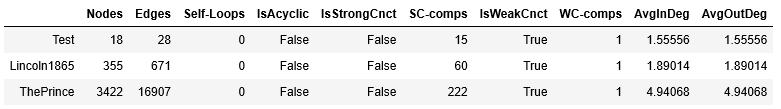

[Instructions](#Instructions)

In [11]:
lstCols = ['Nodes', 'Edges', 'Self-Loops', 
           'IsAcyclic', 'IsStrongCnct', 'SC-comps', 
           'IsWeakCnct', 'WC-comps', 
           'AvgInDeg', 'AvgOutDeg' ]

def summarize_digraphs(lstGraphs):
    df = pd.DataFrame(columns = lstCols,index = [i.graph['name'] for i in lstGraphs])
    #print(df)
    for G in lstGraphs:
                                  #nx.is_strongly_connected(G),nx.number_strongly_connected_components(G),
                                   #nx.is_weakly_connected(G),nx.number_weakly_connected_components(G),
        in_de = list(G.in_degree()) 
        in_dic = {}
        for l in in_de:
            in_dic[l[0]]=l[1]
        out_de = list(G.out_degree()) 
        out_dic = {}
        for l in in_de:
            out_dic[l[0]]=l[1]
        df.loc[G.graph['name']] = [G.number_of_nodes(), G.number_of_edges(), 
                                   G.number_of_selfloops(),nx.is_directed_acyclic_graph(G),
                                   nx.is_strongly_connected(G),nx.number_strongly_connected_components(G),
                                   nx.is_weakly_connected(G),nx.number_weakly_connected_components(G),
                                   pd.Series([*in_dic.values()]).mean(),pd.Series([*out_dic.values()]).mean()]
    return(df)

In [12]:
dfSummary = summarize_digraphs([Gt, Gs, Gp])
sSaveFile = './AS11-TestDFSummary.pkl'
#dfSummary.to_pickle(sSaveFile)
dfSummary

,Nodes,Edges,Self-Loops,IsAcyclic,IsStrongCnct,SC-comps,IsWeakCnct,WC-comps,AvgInDeg,AvgOutDeg
Test,18,28,0,False,False,15,True,1,1.55556,1.55556
Lincoln1865,355,671,0,False,False,60,True,1,1.89014,1.89014
ThePrince,3422,16907,0,False,False,222,True,1,4.94068,4.94068


In [13]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------
dfSumComp = pd.read_pickle(sSaveFile)
assert dfSummary.equals(dfSumComp)
del dfSumComp


### Compare Centrality Measures
**Points: 0.5**

This next function compares node importance for a graph using four different centrality measures. 
- input is a graph (G) and the number of top nodes to return (nTop)
- output is a pandas dataframe
  - Column names are `in_degree`, `out_degree`, `closeness`, `betweenness`
  - There will be nTop rows, where each column contains the node name. Order must be descending by centrality measure. If multiple nodes have the same value, then sort alphabetically within that value.
The output for compare_centrality(Gt,5) will be:
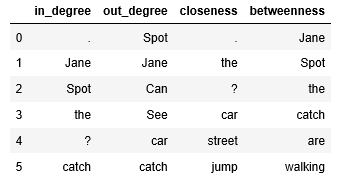


[Instructions](#Instructions)

In [14]:
import operator
from heapq import nlargest
def compare_centrality(G, nTop):
    lstCols = ['in_degree', 'out_degree', 'closeness', 'betweenness']
    in_degree_dict = dict(G.in_degree(G.nodes()))
    sorted_degree = sorted(in_degree_dict.items(), key=operator.itemgetter(1,0))
    sorted_degree = dict(sorted_degree)
    top_largest_in = nlargest(nTop+1, sorted_degree, key=sorted_degree.get)
    #print(top_largest_in)
    out_degree_dict = dict(G.out_degree(G.nodes()))
    sorted_degree = sorted(out_degree_dict.items(), key=operator.itemgetter(1,0))
    sorted_degree = dict(sorted_degree)
    top_largest_out = nlargest(nTop+1, sorted_degree, key=sorted_degree.get)
    #print(top_largest_out)
    close_dict = dict(nx.closeness_centrality(G))
    sorted_degree = sorted(close_dict.items(), key=operator.itemgetter(1,0))
    sorted_degree = dict(sorted_degree)
    top_largest_clo = nlargest(nTop+1, sorted_degree, key=sorted_degree.get)
    #print(top_largest_clo)
    between_dict = dict(nx.betweenness_centrality(G))
    sorted_degree = sorted(between_dict.items(), key=operator.itemgetter(1,0))
    sorted_degree = dict(sorted_degree)
    top_largest_bet = nlargest(nTop+1, sorted_degree, key=sorted_degree.get)
    #print(top_largest_bet)
    df = pd.DataFrame({lstCols[0]:top_largest_in,lstCols[1]:top_largest_out,
                      lstCols[2]:top_largest_clo,lstCols[3]:top_largest_bet},
                      index = np.arange(nTop+1))
    return(df)

In [15]:
dfCt = compare_centrality(Gt, 10)
dfCt

,in_degree,out_degree,closeness,betweenness
0,.,Spot,.,Jane
1,Jane,Jane,the,Spot
2,Spot,Can,?,the
3,the,See,car,catch
4,?,car,street,are
5,catch,catch,jump,walking
6,jump,the,run,down
7,run,and,Jane,and
8,!,are,Spot,car
9,and,chase,catch,jump


In [16]:
dfCs = compare_centrality(Gs, 10)
dfCs

,in_degree,out_degree,closeness,betweenness
0,the,the,the,the
1,",",",",",",","
2,to,to,.,to
3,.,and,to,and
4,of,of,that,of
5,and,that,war,that
6,it,all,it,war
7,that,be,right,in
8,for,it,is,it
9,in,war,woe,all


In [ ]:
#%%timeit -n1 -r1
# This is likely to take over 1 minute to run
dfCp = compare_centrality(Gp, 10)
dfCp

In [ ]:
## This is an automatically graded test cell.
sSaveFile = './AS11-Centrality-t.pkl'
#dfCt.to_pickle(sSaveFile)
dfCtComp = pd.read_pickle(sSaveFile)
assert dfCt.equals(dfCtComp)
del dfCtComp

In [ ]:
## This is an automatically graded test cell.
sSaveFile = './AS11-Centrality-s.pkl'
#dfCs.to_pickle(sSaveFile)
dfCsComp = pd.read_pickle(sSaveFile)
assert dfCs.equals(dfCsComp)
del dfCsComp

In [ ]:
## This is an automatically graded test cell.
sSaveFile = './AS11-Centrality-p.pkl'
#dfCp.to_pickle(sSaveFile)
dfCpComp = pd.read_pickle(sSaveFile)
assert dfCp.equals(dfCpComp)
del dfCpComp

### Normalize Edges
**Points: 0.5**

The edges in the graph currently have a count of how many times that edge occurred in a corpus. This next function goes through every node in the graph, and for each edge leaving that node, assigns the equivalent of a cumulative probability. For example, if node A has three outgoing edges: 
- `(A,B,count=2)`, 
- `(A,C,count=1)`,
- `(A,D,count=3)`.  

This meanst that there were a total of 6 times that a sentence passed through node A. Each edge will be assigned two new attributes named `prob` and `cumprob` so that
- `(A,B,count=2, prob=0.3333, cumprob=0.3333)`, 
- `(A,C,count=1, prob=0.1666, cumprob=0.5)`,
- `(A,D,count=3, prob=0.5,    cumprob=1.0)`.  
Note that the last edge must always have `cumprob=1.0`

The function returns the updated graph. It is expected to modify the passed in graph, so you do not need to make a copy.

[Instructions](#Instructions)

In [ ]:
def normalize_edges(G):
    for n in G.nodes():
        neigours = [i for i in G.neighbors(n)]
        #print(neigours)
        t_c = 0
        if neigours:
            for i in np.arange(len(neigours)):
                t_c += G[n][neigours[i]]['count']
            c_p = 0
            for i in np.arange(len(neigours)):
                G[n][neigours[i]]['prob'] = G[n][neigours[i]]['count']/t_c
                c_p += G[n][neigours[i]]['prob']
                G[n][neigours[i]]['cumprob'] = c_p
#             for i in np.arange(len(neigours)):
#                 print(n,neigours[i],G[n][neigours[i]])
    return G
#Y = normalize_edges(Gt)

In [ ]:
## This is an automatically graded test cell.
Gt = normalize_edges(Gt)
sSaveFile = './AS11-Normalized-t.pkl'
#nx.write_gpickle(Gt, sSaveFile)

np.testing.assert_almost_equal(Gt['See']['Spot']['prob'], 0.6, decimal=4, verbose=True)
np.testing.assert_almost_equal(Gt['and']['Jane']['prob'], 1.0, decimal=4, verbose=True)
np.testing.assert_almost_equal(Gt['Can']['Jane']['prob'], 0.5, decimal=4, verbose=True)
np.testing.assert_almost_equal(Gt['Jane']['are']['prob'], 0.25, decimal=4, verbose=True)
np.testing.assert_almost_equal(Gt['Spot']['chase']['prob'], 0.1666, decimal=4, verbose=True)
np.testing.assert_almost_equal(Gt['the']['street']['prob'], 0.3333, decimal=4, verbose=True)

# Now check the entire graph
GtnComp = nx.read_gpickle(sSaveFile)
assert word_graph_is_isomorphic(GtnComp, Gt)

# From here on use the presaved version to make sure all the cumulative values are on the same edges.
Gt = GtnComp

In [ ]:
## This is an automatically graded test cell.
Gs = normalize_edges(Gs)
sSaveFile = './AS11-Normalized-s.pkl'
#nx.write_gpickle(Gs, sSaveFile)

np.testing.assert_almost_equal(Gs['to']['it']['prob'], 0.03846, decimal=5, verbose=True)
np.testing.assert_almost_equal(Gs['the']['expiration']['prob'], 0.01818, decimal=5, verbose=True)
np.testing.assert_almost_equal(Gs['this']['interest']['prob'], 0.28571, decimal=5, verbose=True)
np.testing.assert_almost_equal(Gs['the']['Union']['prob'], 0.07272, decimal=5, verbose=True)
np.testing.assert_almost_equal(Gs['office']['there']['prob'], 1.0, decimal=5, verbose=True)
np.testing.assert_almost_equal(Gs['less']['fundamental']['prob'], 0.5, decimal=5, verbose=True)
np.testing.assert_almost_equal(Gs['With']['high']['prob'], 0.5, decimal=5, verbose=True)
np.testing.assert_almost_equal(Gs['do']['all']['prob'], 0.25, decimal=5, verbose=True)
np.testing.assert_almost_equal(Gs['men']['should']['prob'], 0.5, decimal=5, verbose=True)
np.testing.assert_almost_equal(Gs['offenses']['which']['prob'], 0.33333, decimal=5, verbose=True)

# Now check the entire graph
GsnComp = nx.read_gpickle(sSaveFile)
assert word_graph_is_isomorphic(GsnComp, Gs)

# From here on use the presaved version to make sure all the cumulative values are on the same edges.
Gs = GsnComp

In [ ]:
## This is an automatically graded test cell.
Gp = normalize_edges(Gp)
sSaveFile = './AS11-Normalized-p.pkl'
#nx.write_gpickle(Gp, sSaveFile)

np.testing.assert_almost_equal(Gp['states']['constituted']['prob'], 0.0434782, decimal=5, verbose=True)
np.testing.assert_almost_equal(Gp[',']['feeling']['prob'], 0.0003877, decimal=5, verbose=True)
np.testing.assert_almost_equal(Gp['have']['borne']['prob'], 0.00333, decimal=5, verbose=True)
np.testing.assert_almost_equal(Gp['over']['those']['prob'], 0.06666, decimal=5, verbose=True)
np.testing.assert_almost_equal(Gp['this']['being']['prob'], 0.012121, decimal=5, verbose=True)
np.testing.assert_almost_equal(Gp['first']['drawn']['prob'], 0.022727, decimal=5, verbose=True)
np.testing.assert_almost_equal(Gp['own']['army']['prob'], 0.014285, decimal=5, verbose=True)
np.testing.assert_almost_equal(Gp['defend']['himself']['prob'], 0.294117, decimal=5, verbose=True)
np.testing.assert_almost_equal(Gp['whoever']['will']['prob'], 0.142857, decimal=5, verbose=True)



In [ ]:
## This is an automatically graded test cell
# Now check the entire graph. This will likely take a couple of minutes to run.
GpnComp = nx.read_gpickle(sSaveFile)
assert word_graph_is_isomorphic(GpnComp, Gp)

# From here on use the presaved version to make sure all the cumulative values are on the same edges.
Gp = GpnComp

### Generate Sentences
**Points: 1.0**  

Now use the word graph to generate a set of sentences. To ensure this gets graded properly, please follow the directions closely.
- There are four inputs
  - the word graph, 
  - the number of sentences to generate, 
  - A list of words to use to start each sentence.
    - You must check to ensure that each of these is a correct starter word. That is, the attribute (`bStart==True`)
    - If a word is not a valid start word or is not present as a node, raise a ValueError exception.
  - optional random seed to use
- The output is a single string containing the requested number of sentences. Think of it as a paragraph. Be sure to strip off any leading or trailing whitespace.
- If the list of starter words is shorter than the requested number of sentences, just cycle through them again in order.  
- If a random seed is supplied, be sure to set the np random seed before doing anything else.
- To make a sentence
  1. The first word will be the start word.
  2. Generate a uniform random number between 0 and 1 (a threshold)
  3. Compare each outgoing edge (use `for e in G.out_edges`)
     - the first edge where the cumulative probability is greater than or equal to the threshold is the edge to use to transition to the next word.
  4. If the next word is a sentence ending word (`bEnd==True`), then the sentence is complete. Otherwise, add the word to the sentence and use it as the start word, cycling back to step 2 above.
- There are a few formatting considerations. Due to tokenizing effects, the spacing for some punctuation must be adjusted.
  - There must be no space between the end of the sentence and the ending punctuation (period, question mark, etc.)
  - If a comma, semicolon, or apostrophe is preceded by a space, you must remove the space.
  - There must be only one space following a sentence before the next sentence begins
  
There are several obvious problems with this simple approach. For example, the words allowed to start questions are not checked, parts of speach are not checked, etc. However, each of these could be addressed in a more complete implementation. Nevertheless, this still generates interesting text!
  




In [ ]:
def generate_sentences(G, numSents, lstStartWords, seed=None):
    for word in lstStartWords:
        if G.has_node(word) == False:
            raise ValueError()
        if G.node[word]['bStart'] == False:
            raise ValueError()
    lst = lstStartWords
    np.random.seed(seed)
    i = 0
    while len(lstStartWords)<numSents:
        lst.append(lstStartWords[i])
        i += 1
        if i == len(lstStartWords):
            i = 0
    sen = []
    co = 0
    for word in lst:
        co += 1
        wr = [word]
        while True:
            rand = np.random.random()
            word = ww(G,word,rand)
            wr.append(word)
            if G.node[word]['bEnd'] == True:
                break
        wrx = ''
        for elem in wr:
            if str(elem).isalnum():
                wrx += ' ' + str(elem)
            else:
                wrx += ''.join(str(elem)) 
        #wr = ' '.join([str(elem) for elem in wr])
        sen.append(wrx)
        if co == numSents:
            break
    sen = ''.join([str(elem) for elem in sen])
    #print(sen)
    return(sen.strip())
def ww(G,word,rand):
    for e in G.out_edges(word):
            if G[word][e[1]]['cumprob'] >= rand:
                return e[1]

In [ ]:
## This is an automatically graded test cell.
nSeed = 42
lstStartWords = ['Can', 'See', 'Spot']

# Check for single sentence creation
assert 'Can Jane catch the car.' == generate_sentences(Gt, 1, lstStartWords, seed=nSeed)

# Check for cycling
sRes = 'Can Jane catch the car. See Spot run. Spot chase the street. Can Spot jump! See Spot jump! Spot and Jane are walking down the car?'
assert sRes == generate_sentences(Gt, 6, lstStartWords, seed=nSeed)

# Check for rejecting invalid starter
try:
    generate_sentences(Gt, 1, ['Jane'], seed=nSeed)
except ValueError:
    pass
else:
    raise AssertionError("Did not raise exception for invalid start word")




In [ ]:
## This is an automatically graded test cell.
nSeed = 1
lstStartWords = ['The', 'If', 'It', 'Yet']

sRes = 'The prayers of the Union without war, reasonably satisfactory and a just God ' + \
       'gives to that any departure from this terrible war, must be said three thousand years ' + \
       'of the war may speedily pass away. If we be paid by the Union even by whom the Union ' + \
       'and it is ventured. It may speedily pass away. Yet, having continued through His own purposes.'

assert sRes == generate_sentences(Gs, 4, lstStartWords, seed=nSeed)

In [ ]:
## This is an automatically graded test cell.
nSeed = 43
lstStartWords = ['The', 'We', 'It', 'For', 'Let']

sRes = "The one's own subjects, namely, yet in nature of all the arms may be seen, " +\
       "or robberies; even in thinking of Moses, Prince of others, King of this springs " +\
       "entirely good arms of the Countess of localities, nevertheless, Prince of a "+\
       "defect in by imitation to die. We have his liking. It is to enterprises prospered "+\
       "by prompt recourse to an acquisition turns into an enemy with infinite. For this "+\
       "question of which princes accuse fortune is useful. Let no longer have fulfilled his resolutions."

assert sRes == generate_sentences(Gp, 5, lstStartWords, seed=nSeed)

### Visualize a Word Graph
This is just a quick method for visualizing a simple word graph. You are welcome to explore the more complicated graphs.

In [ ]:
#The layout function can use any one of these layout programs from graphviz: sfdp, dot, twopi, circo
def draw_word_graph(G, fignum, figsize=(10,7), root=None, layout='circo'):
    fig = plt.figure(fignum, figsize=figsize)
    ax = plt.gca()
    pos = nx.nx_pydot.graphviz_layout(G, root=root, prog=layout)
    nx.draw_networkx(G, pos=pos, ax=ax)
    fig.tight_layout()  

In [ ]:
draw_word_graph(Gt, 1, root='See')

## Graph Structures
The **degree** of a node in an undirected graph is the number of neighboring nodes that are connected. The **degree distribution** of a graph is the _probability distribution_ of the node degrees over the entire network. In real world networks, there are two commonly occuring degree distributions that are frequently analyzed in network research: scale-free networks and small-world networks. The next few problems explore these distributions. 


### Scale-free Networks

Many real-world networks (e.g., the world wide web or power distribution grids) have a large number of nodes with very small degree, and a small number of nodes with a large degree. The degree distribution follows a power law and looks like a straight line when the degree (k) is plotted against the fraction of nodes with that degree on a log-log scale. These are known as scale-free networks. The fraction $P(k)$ of nodes in the network having $k$ connections to other nodes generally follows this form: 

$$P(k) \propto k^{-\alpha}$$  

- $\alpha$ is a constant, with typically $2<\alpha<3$

Scale-free networks typically have short average path lengths, but very low average clustering coefficient.

NetworkX includes several random graph generators. The barabasi_albert_graph function uses a preferential attachment model to generate a random scale free network.  

In [ ]:
# Create a random, scale-free network using the barabasi-albert algorithm.
# This network has 1000 nodes with a preferential edge attachment of 1
Gsf = nx.barabasi_albert_graph(1000, 1, seed=42)
Gsf.graph['name'] = 'ScaleFree'


### Small-world Networks

Social networks are an example of real-world networks where the degree distribution is not scale-free. These are often refered to as small-world networks in the sense that relatively short paths exist between almost any two nodes. A recent study of Facebook connections (Backstrom, et.al, "Four Degrees of Separation", 2012) found that the average path length between facebook users in the United States was 4. 

Small-world networks also typically have short average path lengths, but they have high average clustering coefficient.

The following cell uses the Watts-Strogratz algorithm to generate a small-world graph.

In [ ]:
# Create a random, small world network using the Watts-Strogatz algorithm.
# This network has 1000 nodes, each initially attached to its 6 nearest 
# neighbors, with a rewire probability of 0.4.
Gsw = nx.connected_watts_strogatz_graph(1000,6,0.04,seed=42)
Gsw.graph['name'] = 'SmallWorld'

### Compare Network Structures
**Points: 0.5**  

The following function compares a list of graphs
- Input is a list of undirected graphs
- Output is a pandas dataframe.
  - Column names are 
    - `Avg.Path` (the average shortest path length)
    - `Avg.Cluster` (the average clustering coefficient)
  - Row indexs are the graph level attribute `name`
  
[Instructions](#Instructions)  

In [ ]:
def compare_network_structures( lstG ):
    lstCols = ['Avg.Path','Avg.Cluster']
    df = pd.DataFrame(columns = lstCols,index = [i.graph['name'] for i in lstG])
    for G in lstG:
        df.loc[G.graph['name']] = [nx.average_shortest_path_length(G),nx.average_clustering(G)]
    return df

In [ ]:
## This is an automatically graded test cell.
df = compare_network_structures([Gsf, Gsw])

np.testing.assert_almost_equal(df.loc['ScaleFree','Avg.Path'],     6.433, decimal=3, verbose=True)
np.testing.assert_almost_equal(df.loc['ScaleFree','Avg.Cluster'],  0.000, decimal=3, verbose=True)
np.testing.assert_almost_equal(df.loc['SmallWorld','Avg.Path'],    8.852, decimal=3, verbose=True)
np.testing.assert_almost_equal(df.loc['SmallWorld','Avg.Cluster'], 0.544, decimal=3, verbose=True)

### Plot Network Degree Distribution
**Points: 0.5**  

The next function will help visualize the difference between a scale-free network and a small world network.
- The input to the function is an undirected graph, a figure number, and the figure size
- The function must produce two side-by-side plots. 
  - The left plot is a probability histogram of the degree values for all nodes in the graph. use sns.distplot.
  - The right plot is a scatter plot on a log/log scale. The x axis is the degree, and the y axis is the count of nodes of that degree.
  - Use the graph's `name` attribute to put a supertitle on the plot
  
The plot for the scale free network, `Gsf` looks like this:
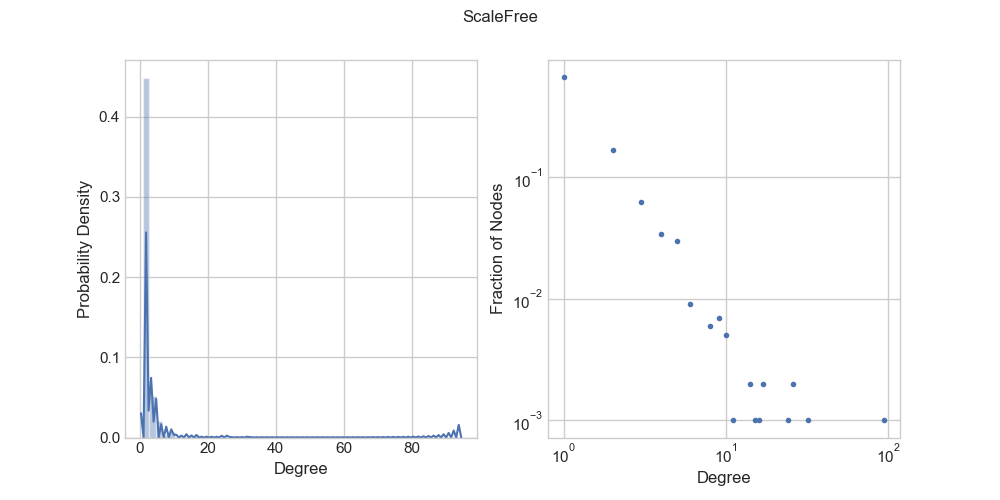
  
[Instructions](#Instructions)  

In [ ]:
import collections
import operator
def plot_degree_distribution(G, fignum, figsize=(10,5)):
    # Set up the figure
    fig, axes = plt.subplots(num=fignum, nrows=1, ncols=2, figsize=figsize, dpi=100, clear=True)
    degrees = [G.degree(n) for n in G.nodes()]
    sns.distplot(degrees,hist=True, kde=True,ax = axes[0])
    axes[0].set_xlabel('Degree')
    axes[0].set_ylabel('Probability Density')
    #print(nx.degree_centrality(G))
    x = nx.degree_centrality(G).keys()
    y = nx.degree_centrality(G).values()
    #axes[1].scatter(x,y)
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    sns.scatterplot(deg, cnt,ax = axes[1],s = 20)
    axes[1].set_xlabel('Degree')
    axes[1].set_ylabel('Fraction of Nodes')
    axes[1].set(xscale="log", yscale="log")
    plt.suptitle(G.graph['name'])



In [ ]:
# Plot the degree distribution for Gsf
fignum = 2
plot_degree_distribution(Gsf, fignum, figsize=(10,5))

In [ ]:
# Plot the degree distribution for Gsw
fignum = 3
plot_degree_distribution(Gsw, fignum, figsize=(10,5))

### Structure for Word Networks

Now determine whether the network structures for the word graphs more like scale free networks or small world networks.

In the next cell, convert the two main word graphs (`Gp` and `Gs`) to undirected graphs named (`Gpu` and `Gsu`), then compare them using the `compare_graph_structures` function to create a dataframe named `dfwn`.


[Instructions](#Instructions)

In [ ]:
# convert the word graphs and compare them
dfwn = pd.DataFrame()
Gpu = Gp.to_undirected()
Gsu = Gs.to_undirected()
dfwn = compare_network_structures([Gpu, Gsu])

In [ ]:
## This is an automatically graded test cell.
np.testing.assert_almost_equal(dfwn.loc['Lincoln1865','Avg.Path'],    3.407, decimal=3, verbose=True)
np.testing.assert_almost_equal(dfwn.loc['Lincoln1865','Avg.Cluster'], 0.138, decimal=3, verbose=True)


In [ ]:
# There are hidden tests for The Prince

In [ ]:
# Use the comparison plots
plot_degree_distribution(Gsu,4)

In [ ]:
# Use the comparison plots
plot_degree_distribution(Gpu,5)

Looking at the average shortest path length, the average clustering coefficient, and the above two plots, have the following function return a string with one of these responses (exact string match required):
- `scale-free`
- `small-world`

In [ ]:

def word_plots_are_more_like():
    return 'scale-free'

In [ ]:
## This is an automatically graded test cell.
# This is a hidden test



## Geographic Networks
### The osmnx Library

This section is just for reference and fun.

The [Open Street Map](https://wiki.openstreetmap.org/wiki/Main_Page) project maintains a wealth of geographic related information. The osmnx python library provides a simple API to access the OSM data and produce a NetworkX graph. A good blog entry on this is here: https://geoffboeing.com/2016/11/osmnx-python-street-networks/. 

In the following cells, the lines used to download and save maps for Toledo, Spain and Fort Lauderdale, Florida are commented out.

[Instructions](#Instructions)

In [ ]:
sToledoPath = os.path.join(dataroot,'Misc','ToledoSpain.graphml')
#GtsOrig = ox.graph_from_place('Toledo, Spain', network_type='drive')
#ox.save_graphml(GtsOrig, sToledoPath )
Gts = ox.load_graphml(sToledoPath)
print(nx.info(Gts))
fig, ax = ox.plot_graph(Gts)

In [ ]:
sFTLPath = os.path.join(dataroot,'Misc','FortLauderdale.graphml')
#GftlOrig = ox.graph_from_place('Fort Lauderdale, Florida, USA', network_type='drive')
#ox.save_graphml(GftlOrig, sFTLPath )
Gftl = ox.load_graphml(sFTLPath)
print(nx.info(Gftl))
fig, ax = ox.plot_graph(Gftl)